
**RED NEURONAL 3**
> En base a la experiencia obtenida con los modelos anteriores, en este notebook buscaremos generar un modelo con una red neuronal, que en base a datos historicos, nos permita obtener predicciones en horizontes amplios de tiempo.

> Se busca poder entrenar el modelo con más de una caracteristica para así aprovechar toda la información de la que disponemos y buscar aumentar además la precision de los pronosticos en base a ajustes del modelo y distintas arquitecturas del mismo.





1.   **Bibliotecas necesarias**




  Importamos las librerias necesarias para todo el script: 

1.   **Matplotlib** para realizar las gráficas
2.   **Pandas** para procesar la base de datos
3.   **Numpy** para convertir la base de datos en arreglos numéricos
4.   **Os** para acceder a los archivos mediante rutas de almacenamiento
5.   **Seaborn** para realizar análisis gráficos a los datos mediante análisis estadisticos
6.   **Drive** se utiliza para acceder a las carpetas de datos del drive de un correo asociado
7.   **Tensorflow** es la librería mediante la cual se generan los modelos de redes neuronales



In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from google.colab import drive 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6) #Definimos el tamaño para las figuras de matplotlib
mpl.rcParams['axes.grid'] = False


2.   **Conjunto de datos**



En la siguiente celda de codigo se llama una función de google colab mediante la cual se accede a la carpeta de drive, luego se define la ruta de acceso a la base de datos previamente procesados para la realización del modelo y se procesa mediante la librería `Pandas`:

In [ ]:
drive.mount('/content/gdrive') # Se monta en colab
ruta = 'gdrive/My Drive/Colab Notebooks/Proyecto Solar/KENYA_LIMPIO.csv' #ruta donde se encuentra el dataset 
data = pd.read_csv(ruta,encoding='utf-8') # Se hace la respectiva lectura, no se añade encabezado o indice, por lo que pondrá por defecto la numeracion
data.set_index('time', inplace=True) # Establecemos cual será el indice del dataframe
data.head() # Se muestran las 5 primeras filas del dataframe

Mounted at /content/gdrive


,dhi_pyr,ghi_pyr_1,ghi_pyr_2,air_temperature,relative_humidity,barometric_pressure,precipitation,wind_speed,wind_from_direction,gti_clean,gti_soil,gti_monthly,sensor_cleaning,Hour
time,,,,,,,,,,,,,,
2019-12-12 00:00:00,0.0,0.0,0.0,22.725000,99.003998,948.445923,0.0,1.073283,169.845993,0.0,0.0,0.0,0.0,0
2019-12-12 00:15:00,0.0,0.0,0.0,22.580830,98.758003,948.415283,0.0,0.727417,204.165405,0.0,0.0,0.0,0.0,0
2019-12-12 00:30:00,0.0,0.0,0.0,22.600500,98.003998,948.335022,0.0,0.415667,188.567200,0.0,0.0,0.0,0.0,0
2019-12-12 00:45:00,0.0,0.0,0.0,22.610661,96.216003,948.203613,0.0,1.380333,233.490707,0.0,0.0,0.0,0.0,0
2019-12-12 01:00:00,0.0,0.0,0.0,22.651331,97.160004,948.038818,0.0,2.620333,181.092804,0.0,0.0,0.0,0.0,1


3. **Selección de datos para entrenar la red neuronal**

Luego de analizar las corelaciones, se llego a la conclusion de que los datos que más influencia tienen sobre los valores de irradianza `GHI` son los que se seleccionaron y se colocaron en un nuevo dataset:



In [ ]:
#features_considered = ['GHI']#,	'DOY','PST','Precipitation', 'Zenith',	'Humidity'] # Definimos las columnas que se van a utilizar para el entrenamiento del modelo
features_considered = ['ghi_pyr_1']
features = data[features_considered] # Creamos un dataframe con solo estos datos
features.head() #Se muestran los 5 primeros datos

,ghi_pyr_1
time,
2019-12-12 00:00:00,0.0
2019-12-12 00:15:00,0.0
2019-12-12 00:30:00,0.0
2019-12-12 00:45:00,0.0
2019-12-12 01:00:00,0.0


Graficamos todos los datos con el fin de apreciar de manera general su comportamiento a lo largo del tiempo con la función plot asociada a la librería `Pandas`.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0357be6d0>],
      dtype=object)

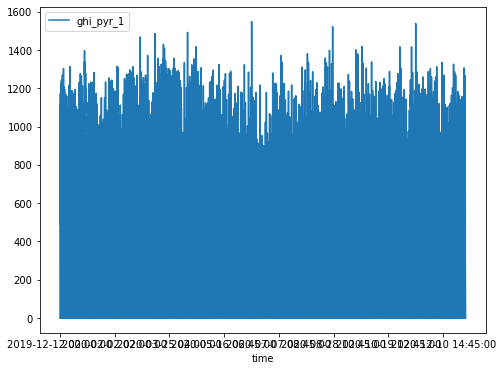

In [ ]:
features.plot(subplots=True) # Graficamos las columnas de datos para observar su comportamiento

Se convierte el conjunto de datos en un arreglo de `numpy` definiendo la cantidad de datos que se van a utilizar para el proceso y luego se estandarizan con una normalización:


In [ ]:
TRAIN_SPLIT = int(len(features)*0.8//1) #Definimos la cantidad de datos que se van a usar para el entrenamiento del modelo
dataset = features.values # Convertimos el dataframe en un arreglo de numpy

In [ ]:
scaler = StandardScaler()
dataset = scaler.fit_transform(dataset)

In [ ]:
def ventanas(dataset,xsize,ysize,indexin,indexf):
  #dataset = dataset.T
  n=0
  x=[]
  y=[]
  for i in range(int(((indexf-indexin)/xsize)-1)):
    x.append(dataset[n+indexin:n+indexin+xsize].T)
    y.append(dataset[n+indexin+xsize:n+indexin+xsize+ysize].T)
    n+=xsize
  return np.array(x),np.array(y)


In [ ]:
x_train1,y_train1=ventanas(dataset,96,96,0,TRAIN_SPLIT)
x_val1,y_val1=ventanas(dataset,96,96,308*96,len(dataset))

In [ ]:
x_train1.shape

(307, 1, 96)

4.   **Función para la partición de datos en caracteristicas y etiquetas**

Utilizando la función anterior, creamos el set de entrenamiento y de validación para la red neuronal con la estructura mostrada.

In [ ]:
#scalerx = StandardScaler()
#scalery = StandardScaler()
#x_train = scalerx.fit_transform(x_train)
#y_train = scalery.fit_transform(y_train)
#x_val = scalerx.transform(x_val)
#y_val = scalery.transform(y_val)


6.   **Función para visualizar los resultados obtenidos**

La siguiente de función se utiliza para generar gráficos a partir de una ventana de tiempo como las que se definieron anteriormente, esta se utilizará para mostrar:

*   La ventana de tiempo utilizada para la predicción
*   El valor real de los datos futuros tomado del set de validación
*   El valor de las predicciones que arroja la red neuronal



In [ ]:
def create_time_steps(length): # Función que crea un array en un rango determinado por el tamaño de la ventana de datos
    return list(range(-length, 0))

# history: Un arreglo con la ventana de datos usada para la predicción
# true_future: Arreglo con los datos conocidos que deberia arrojar la predicción 
# prediction: Arreglo con las predicciones obtenidas

def multi_step_plot(history, true_future, prediction): 
    plt.figure(figsize=(12, 6)) # Se define el tamaño de la figura
    num_in = create_time_steps(len(history)) #Tamaño de la curva de datos pasados
    num_out = len(true_future) # Tamaño de la curva de datos futuros
    plt.plot(num_in, history, label='History') # Graficamos datos pasados
    plt.plot(np.arange(num_out)/STEP, (true_future), 'y--',
           label='True Future') #Graficamos datos furutos
    if prediction.any(): # Si se ingresan datos sobre las predicciones
        plt.plot(np.arange(num_out)/STEP, (prediction), 'r--', #Grafica tambien las predicciones
                 label='Predicted Future')
    plt.legend(loc='upper left') # Ajustes de la grafica
    plt.grid()
    plt.show() # Se muestra la grafica

Se muestra un ejemplo del gráfico que arroja la función, pero en este caso, no están incluidas predicciones, pero en cuanto se incluyan, se veran en forma de puntos rojos.

7.   **Red neuronal**

En las siguientes celdas de texto se va a definir el modelo de ML que se utilizará para realizar las predicciones buscadas, este modelo consta de una capa de entrada, y dos capas intermedias de neuronas tipo LSTM, con una respectiva función de activación.

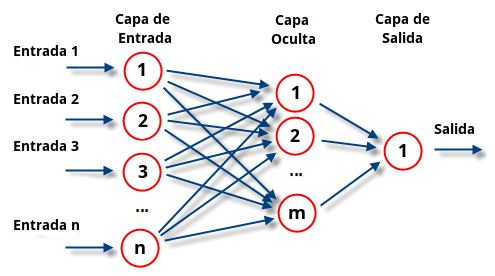

Fig 1. [Perceptrón Multicapa](https://es.wikipedia.org/wiki/Perceptr%C3%B3n_multicapa)

La cantidad de neuronas ajustada de forma manual para maximizar su precisión de entrenamiento y una capa de salida con n neuronas con n datos de predicción buscados.

Además se compila el modelo y dentro de dicha compilación estan incluidas configuraciónes, donde las configuraciones son:

*   **optimizer**: Optimizador utilizado
*   **loss**: Métrica utilizada para determinar las perdidas del modelo
*   **metrics**: Guarda los valores de las metricas en cada epoca de entrenamiento

**MODELO 1**

In [ ]:
batch_size=1

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3,padding="causal",activation="tanh", batch_input_shape= (batch_size, x_train1.shape[1], x_train1.shape[2])),
    tf.keras.layers.LSTM(100, activation="tanh", stateful= True, dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(150, activation="tanh", stateful= True, dropout=0.2,return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(96))
])

model.compile(optimizer='adam', loss='mean_absolute_error')# Compilamos el modelo y definimos los ajustes ya explicados

In [ ]:
model.fit(x_train1, y_train1, epochs=100, verbose=1, batch_size=batch_size, shuffle=False)

Epoch 1/100
307/307 [==============================] - 16s 5ms/step - loss: 0.1783
Epoch 2/100
307/307 [==============================] - 2s 5ms/step - loss: 0.1368
Epoch 3/100
307/307 [==============================] - 2s 5ms/step - loss: 0.1347
Epoch 4/100
307/307 [==============================] - 2s 5ms/step - loss: 0.1341
Epoch 5/100
307/307 [==============================] - 2s 5ms/step - loss: 0.1342
Epoch 6/100
307/307 [==============================] - 2s 5ms/step - loss: 0.1342
Epoch 7/100
307/307 [==============================] - 2s 5ms/step - loss: 0.1344
Epoch 8/100
307/307 [==============================] - 2s 5ms/step - loss: 0.1350
Epoch 9/100
307/307 [==============================] - 2s 5ms/step - loss: 0.1355
Epoch 10/100
307/307 [==============================] - 2s 5ms/step - loss: 0.1358
Epoch 11/100
307/307 [==============================] - 2s 5ms/step - loss: 0.1364
Epoch 12/100
307/307 [==============================] - 2s 5ms/step - loss: 0.1372
Epoch 13/100

8.  **Resultados**

En esta sección del codigo se observarán y analizarán los resultados obtenidos realizando predicciones con el modelo que generamos.  ✌

In [ ]:
model.evaluate(x_val1, y_val1),model.evaluate(x_train1, y_train1)

10/10 [==============================] - 0s 4ms/step - loss: 0.1131


(0.09732654690742493, 0.11308982223272324)

**CÁLCULO DE ERRORES**

In [ ]:
n=0
MAPE = []
MAE = []
RMSE = []
for i in range(len(x_train1)):
  xt= x_train1[n][0]
  yt= y_train1[n][0]
  y=model.predict(np.array([x_train1[n]]))[0][0]
  mape= ((y-yt).mean())*100
  xt= scaler.inverse_transform(xt.reshape((96,1))).reshape((1,96))
  yt= scaler.inverse_transform(yt.reshape((96,1))).reshape((1,96)) 
  y=scaler.inverse_transform(y.reshape((96,1))).reshape((1,96))
  mae = abs((y-yt).mean())
  rmse = abs(y-yt).mean()

  MAPE.append(mape)
  MAE.append(mae)
  RMSE.append(rmse)
  n+=1
tMAPE =np.array(MAPE).mean()
tMAE =np.array(MAE).mean()
tRMSE =np.array(RMSE).mean()

n=0
MAPE = []
MAE = []
RMSE = []
for i in range(len(x_val1)):
  xt= x_val1[n][0]
  yt= y_val1[n][0]
  y=model.predict(np.array([x_val1[n]]))[0][0]
  mape= ((y-yt).mean())*100
  xt= scaler.inverse_transform(xt.reshape((96,1))).reshape((1,96))
  yt= scaler.inverse_transform(yt.reshape((96,1))).reshape((1,96)) 
  y=scaler.inverse_transform(y.reshape((96,1))).reshape((1,96))
  mae = abs((y-yt).mean())
  rmse = abs(y-yt).mean()

  MAPE.append(mape)
  MAE.append(mae)
  RMSE.append(rmse)
  n+=1
  
vMAPE =np.array(MAPE).mean()
vMAE =np.array(MAE).mean()
vRMSE =np.array(RMSE).mean()

In [ ]:
print("----------------------------------")
print("|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento")
print("----------------------------------")
print("%9.4f%12.4f%12.4f"%(tMAE,tMAPE,tRMSE))
print("----------------------------------")
print("|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación")
print("----------------------------------")
print("%9.4f%12.4f%12.4f"%(vMAE,vMAPE,vRMSE))
print("----------------------------------")

----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento
----------------------------------
  26.5181      5.0539     46.6399
----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación
----------------------------------
  21.5705      3.5622     40.2253
----------------------------------


**CON LOS DATOS DE ENTRENAMIENTO**

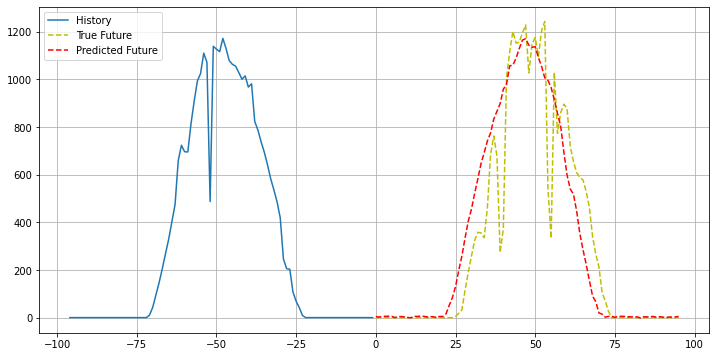

El MAPE para un horizonte de 24h es: 4.333845019349781 %


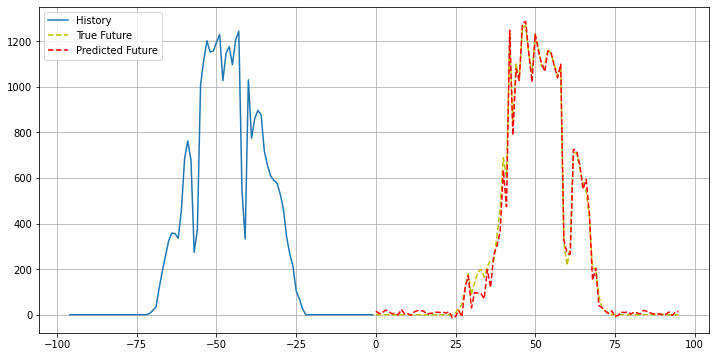

El MAPE para un horizonte de 24h es: 1.5533796183214017 %


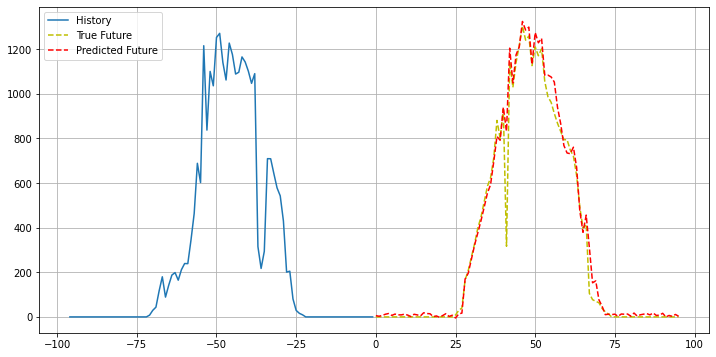

El MAPE para un horizonte de 24h es: 4.735325595512263 %


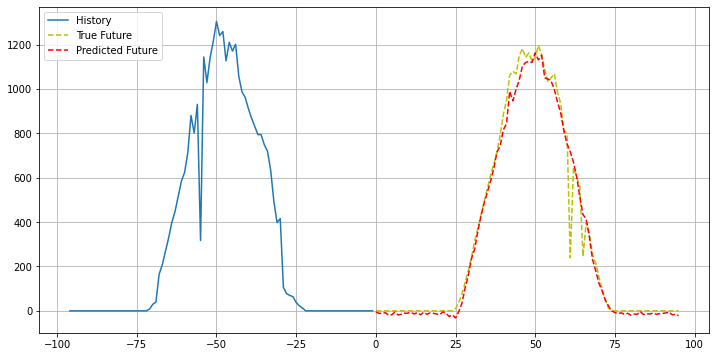

El MAPE para un horizonte de 24h es: 3.441193146738238 %


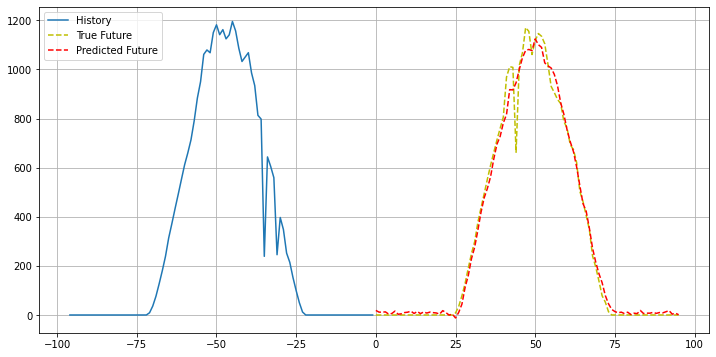

El MAPE para un horizonte de 24h es: 0.14517580153974158 %


In [ ]:
STEP = 1
n=0
for i in range(5):
  xt= x_train1[n][0]
  yt= y_train1[n][0]
  y=model.predict(np.array([x_train1[n]]))[0][0]
  mae= abs((y-yt).mean())
  xt= scaler.inverse_transform(xt.reshape((96,1))).reshape((1,96))
  yt= scaler.inverse_transform(yt.reshape((96,1))).reshape((1,96)) 
  y=scaler.inverse_transform(y.reshape((96,1))).reshape((1,96))

  multi_step_plot(xt[0], yt[0], y[0])
  print('El MAPE para un horizonte de 24h es:',mae*100,'%')
  n+=1

**CON LOS DATOS DE VALIDACIÓN**

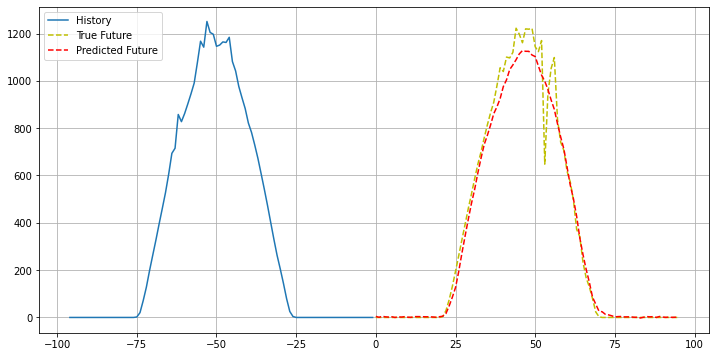

El MAPE para un horizonte de 24h es: 4.026394139874757 %


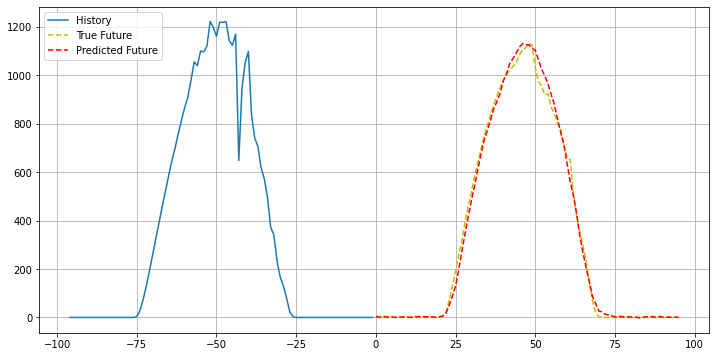

El MAPE para un horizonte de 24h es: 0.19066210588140586 %


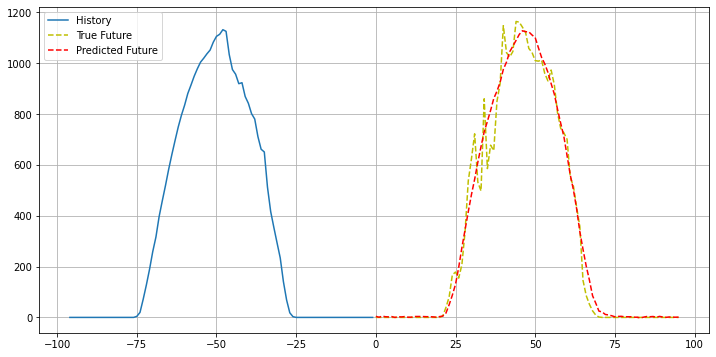

El MAPE para un horizonte de 24h es: 1.7336254835859513 %


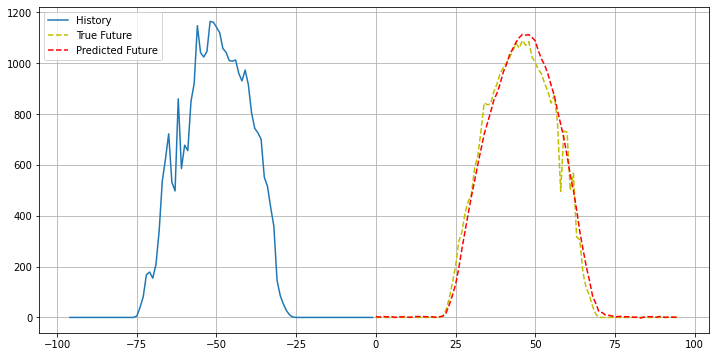

El MAPE para un horizonte de 24h es: 1.2257852672616267 %


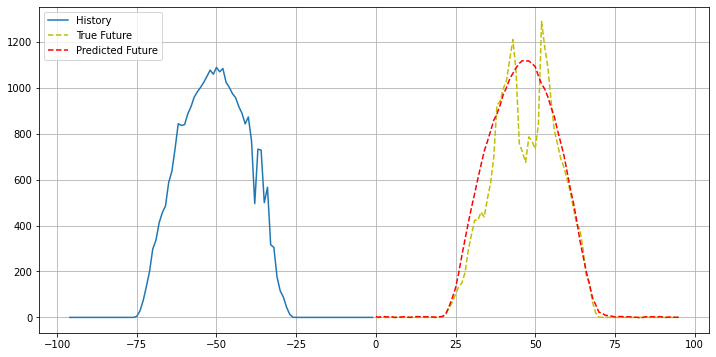

El MAPE para un horizonte de 24h es: 10.099260535290615 %


In [ ]:
STEP = 1
n=0
for i in range(5):
  xt= x_val1[n][0]
  yt= y_val1[n][0]
  y=model.predict(np.array([x_val1[n]]))[0][0]
  mae= abs((y-yt).mean())
  xt= scaler.inverse_transform(xt.reshape((96,1))).reshape((1,96))
  yt= scaler.inverse_transform(yt.reshape((96,1))).reshape((1,96)) 
  y=scaler.inverse_transform(y.reshape((96,1))).reshape((1,96))

  multi_step_plot(xt[0], yt[0], y[0])
  print('El MAPE para un horizonte de 24h es:',mae*100,'%')
  n+=1